# Similarity of descriptions (reviews)
## Following W4
* Shingles - k-shingle is any substring of length k found within the document.
* Minhashing - Hashing each shingle to a number and keeping the minimum of the hash values.
* Signatures - Minhashing for multiple hash functions and keeping the minhash values for each hash function in a list.
* Jaccard similarity - The fraction of the number of elements in the intersection of two sets and the number of elements in the union of the two sets. Approximated by counting number of minhash values in the signature lists that match and dividing by the number of hash functions.
* Locality-Sensitive Hashing (LSH) - Dividing the signature matrix into bands and hashing the bands. If two signatures are similar, they will hash to the same bucket with high probability.



In [22]:
import csv
import mmh3
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
# Load descriptions from data/movies_metrics.csv
Movies = pd.read_csv('movie_titles_and_ids.csv')
Movies.head(2)

,Name,ID,Year,Length,Age,Rating,Description
0,The Shawshank Redemption,tt0111161,1994,2h 22m,15,9.3 (3M),A banker convicted of uxoricide forms a friend...
1,The Godfather,tt0068646,1972,2h 55m,15,9.2 (2.1M),The aging patriarch of an organized crime dyna...


## Speedrun with movie titles

In [95]:
titles = [f'{name} ({year})' for name, year in zip(Movies['Name'], Movies['Year'])]
len(titles)

3122

### Jaccard similarity

In [96]:
def jaccard(S, T):
    intersection = len(S & T)
    union = len(S | T)
    return intersection / union

movie_1 = random.choice(titles)
movie_2 = random.choice(titles)
print(movie_1, '-', movie_2)

# Split words into sets
movie_1 = set(movie_1.split())
movie_2 = set(movie_2.split())

print(movie_1, '-', movie_2)
print(jaccard(movie_1, movie_2))


Annihilation (2018) - Jeepers Creepers 2 (2003)
{'(2018)', 'Annihilation'} - {'2', 'Creepers', '(2003)', 'Jeepers'}
0.0


In [97]:
similar

[('True Grit (1969)', 'True Grit (2010)', 0.25),
 ('Solaris (2002)', 'Solaris (1972)', 0.24),
 ('Adore (2013)', 'Stand by Me (1986)', 0.23),
 ('Peter Pan (1953)', 'Pan (2015)', 0.25),
 ('Goldfinger (1964)', 'Diamonds Are Forever (1971)', 0.28),
 ('Creed (2015)', 'Creed II (2018)', 0.28),
 ('Hellraiser: Inferno (2000)', 'Laura (1944)', 0.23),
 ('The Longest Yard (2005)', 'Mean Machine (2001)', 0.29),
 ('The Innocents (1961)', 'The Others (2001)', 0.26),
 ('Coach Carter (2005)', 'Overcomer (2019)', 0.26),
 ('A Star Is Born (1954)', 'A Star Is Born (2018)', 0.28),
 ('The Hobbit: An Unexpected Journey (2012)',
  'The Hobbit: The Desolation of Smaug (2013)',
  0.31)]

In [127]:
def find_matches(titles, threshold):
    # Now compare all pairs of candidates
    similar = []
    for i, A in tqdm(enumerate(titles)):
        for j in range(i+1, len(titles)):
            B = titles[j]

            sim = jaccard(set(A.split()), set(B.split()))
            if sim > threshold:
                similar.append((A, B, sim))
    return similar

_similar = find_matches(titles, 0.67)

# 10 secs

3122it [00:10, 285.72it/s]


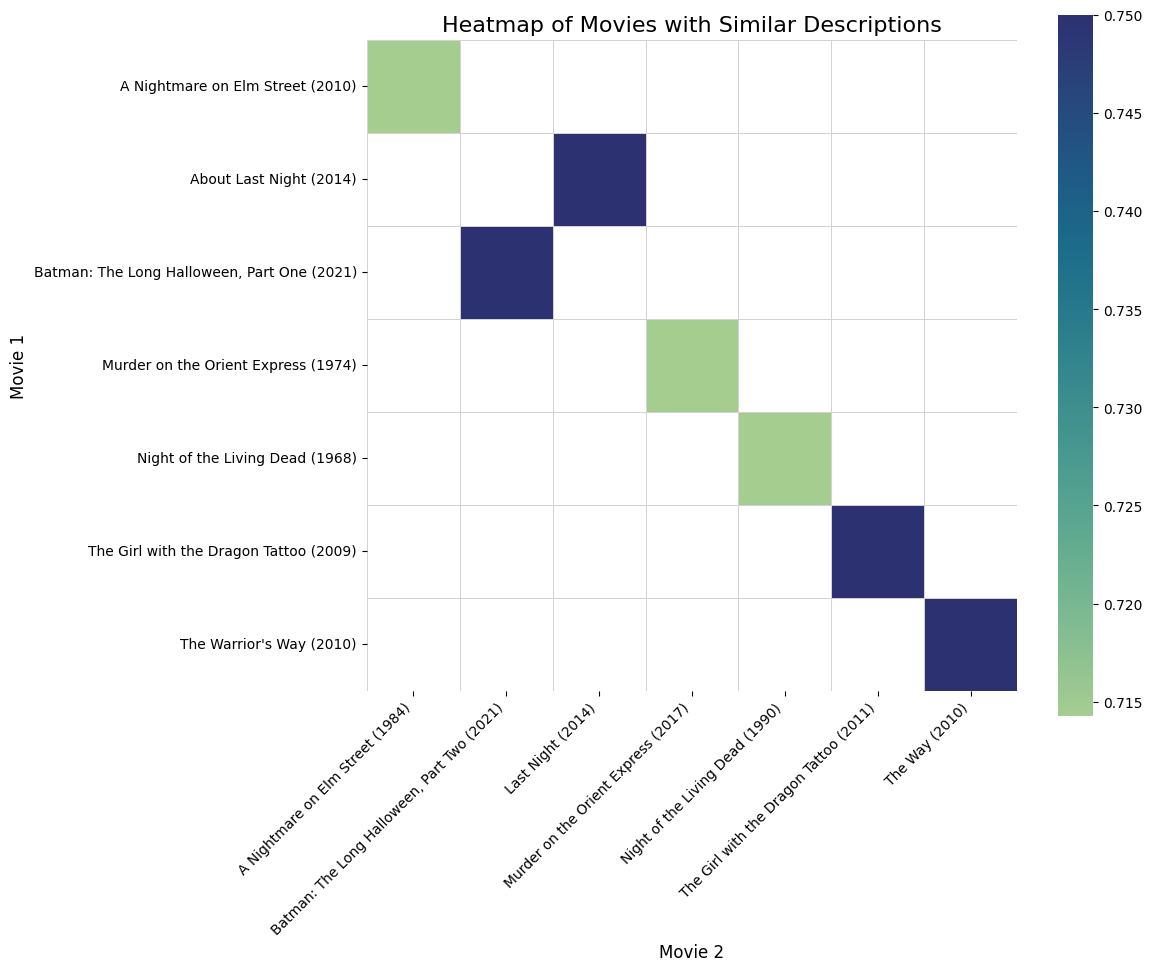

In [128]:
def plot_HeatMap(similar):
    # Extract keys (pairs of movies) and values (similarity scores) from the list of tuples
    key1 = [pair[0] for pair in similar]  # First movie in each tuple
    key2 = [pair[1] for pair in similar]  # Second movie in each tuple
    values = [pair[2] for pair in similar]  # Similarity scores

    # Create a dataframe from the keys and values
    df = pd.DataFrame({'key1': key1, 'key2': key2, 'values': values})

    # Create a pivot table from the dataframe
    df_pivot = df.pivot(index='key1', columns='key2', values='values')

    # Set up the plot
    plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
    sns.heatmap(
        df_pivot,
        cmap='crest',
        annot=False,  # No annotations
        cbar=True,
        mask=df_pivot.isna(),
        linewidths=0.5,  # Add grid lines between cells
        linecolor='lightgray',  # Grid line color
        square=True  # Ensure square cells
    )

    # Customize labels and title
    plt.title('Heatmap of Movies with Similar Descriptions', fontsize=16)
    plt.xlabel('Movie 2', fontsize=12)
    plt.ylabel('Movie 1', fontsize=12)

    # Rotate tick labels for readability
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_HeatMap(_similar)

## Larger descriptions

In [41]:
descriptions = Movies['Description']
len(descriptions)

3123

### Preprocessing (Nojan)

In [25]:
from bs4 import BeautifulSoup
import nltk
import re 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:

def simple_preprocess_text(corpus):
    # Remove HTML tags
    corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]

    # Remove urls
    corpus = [re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) for text in corpus]
    
    # Remove non-alphabetic characters
    corpus = [re.sub("[^a-zA-Z]", " ", text) for text in corpus]

    # Convert to lowercase
    corpus = [text.lower() for text in corpus]

    return corpus

def preprocessing_lemmatization(corpus):
    # Tokenize the text (split it into words)
    corpus = [word_tokenize(text) for text in corpus]

    # Remove stop words (The, a, on, etc)
    stop_words = set(stopwords.words("english"))
    corpus = [[word for word in text if word not in stop_words] for text in corpus]

    # Lemmatization,
    # AKA remove word endings to get the base form
    lemmatizer = nltk.stem.WordNetLemmatizer()
    corpus = [[lemmatizer.lemmatize(word) for word in text] for text in corpus]

    # Join the words back into one string
    corpus = [" ".join(text) for text in corpus]

    return corpus

descriptions = simple_preprocess_text(descriptions)
descriptions = preprocessing_lemmatization(descriptions)

C:\Users\PC\AppData\Local\Temp\ipykernel_5428\3516315473.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  corpus = [BeautifulSoup(text, "html.parser").get_text() for text in corpus]


### Shingle

In [27]:
def shingle(s, q):
    return {s[i:i+q] for i in range(len(s) - q + 1)}

### Minhashing and Signature

In [28]:
import hashlib
def listhash(shingle, seed):
	return int(hashlib.sha256((shingle + str(seed)).encode('utf-8')).hexdigest(), 16) % 2**32-1

def minhash(shingles, seed):
    return min(listhash(s, seed) for s in shingles)

def signature(shingles, k):
	return [minhash(shingles, seed) for seed in range(k)]

### Signature for entire dataset

In [29]:
q = 5 # length of shingle  (5 ok for emails)
k = 100 # number of minhashes
keys = [f'{name} ({year})' for name, year in zip(Movies['Name'], Movies['Year'])]
# docs = Movies.set_index('Name')['Description'].to_dict() # dictionary mapping document id to document contents
docs = {key : desc for key, desc in zip(keys, descriptions)}

Observing that there will be an intersection of shingles in documents, this can be used to define the signatures for the entire dataset. Instead of iterating over documents and defining signatures individually, iterate over shingles

In [30]:
def MakeSignatures(docs, shingles, U):
    SIG = {doc : [float('inf') for _ in range(k)] for doc in docs}

    for s in tqdm(U):
        # hashes = signature(s, k)
        hashes = [listhash(s, seed) for seed in range(k)]
        for doc in docs:
            if s in shingles[doc]:
                for i in range(k):
                    SIG[doc][i] = min(hashes[i], SIG[doc][i])
    return SIG

shingles = {doc: shingle(docs[doc], q) for doc in docs}
U = set([s for doc in shingles for s in shingles[doc]])  # All shingles

signatures = MakeSignatures(docs, shingles, U)

100%|██████████| 63281/63281 [00:55<00:00, 1135.33it/s]


### Approximate Jaccard similarity

In [ ]:
# Approximate Jaccard similarity using minhash signatures
def approximate_jaccard(A, B, signatures):
    return sum(i == j for i, j in zip(signatures[A], signatures[B])) / k

In [32]:
# Test
A, B = random.sample(keys, 2)
print(A, '-', B)

doc1 = docs[A]
doc2 = docs[B]
shingle1 = shingle(doc1, q)
shingle2 = shingle(doc2, q)
signature1 = signature(shingle1, k)
signature2 = signature(shingle2, k)

# Exact Jaccard similarity
print(jaccard(shingle1, shingle2))

# Approximate Jaccard similarity
print(approximate_jaccard(A, B, signatures))

Dead Calm (1989) - Fear Street: Part Two - 1978 (2021)
0.0
0.0


In [33]:
# Find most similar by description
mx = 0.0
most_similar = None
for i, A in enumerate(keys):
    for j in range(i+1, len(keys)):
        B = keys[j]
        # shingle1 = shingle(docs[A], q)
        # shingle2 = shingle(docs[B], q)
        # sim = jaccard(shingle1, shingle2)
        sim = approximate_jaccard(A, B, signatures)
        if sim > mx:
            mx = sim
            most_similar = (A, B)
print(mx, most_similar)
# Jaccard 

1.0 ('The Mummy Returns (2001)', 'The Mummy Returns (2001)')


In [34]:
A, B = random.sample(keys, 2)
print(A, '-', B)
# Exact Jaccard similarity
print(jaccard(shingle1, shingle2))

# Approximate Jaccard similarity
matches = sum(1 for i, j in zip(signature1, signature2) if i == j)
print(matches)
print(matches / k)
# jaccard(docs[A], docs[B]), approximate_jaccard(A, B, signatures)

In Bruges (2008) - The Machinist (2004)
0.0
0
0.0


### Locality-Sensitive Hashing
Pick $b$ and $r$ such that $k = br$ and $(1/b)^{1/r} \approx s$, where $s$ is the similarity threshold.

In [35]:
# (1/b)**(1/r)

In [ ]:
def fill_buckets(signatures, b, r):
    buckets = {i: {} for i in range(b)}
    for doc in signatures:
        for i in range(b):
            h = hash(tuple(signatures[doc][i*r:(i+1)*r]))
            if h not in buckets[i]:
                buckets[i][h] = []
            buckets[i][h].append(doc)
    return buckets

def lsh(signatures, threshold):
    b = 50
    r = k // b
    buckets = fill_buckets(signatures, b, r)

    candidates = set()
    for bucket in buckets:
        for h in buckets[bucket]:
            if len(buckets[bucket][h]) > 1:
                for doc in buckets[bucket][h]:
                    candidates.add(doc)
    candidates = list(candidates)
    
    # Now compare all pairs of candidates
    similar = []
    for i, A in enumerate(candidates):
        for j in range(i+1, len(candidates)):
            B = candidates[j]
            sim = approximate_jaccard(A, B, signatures)
            if sim > threshold:
                similar.append((A, B, sim))
    return similar

_similar = lsh(signatures, 0.22)

### HeatMap

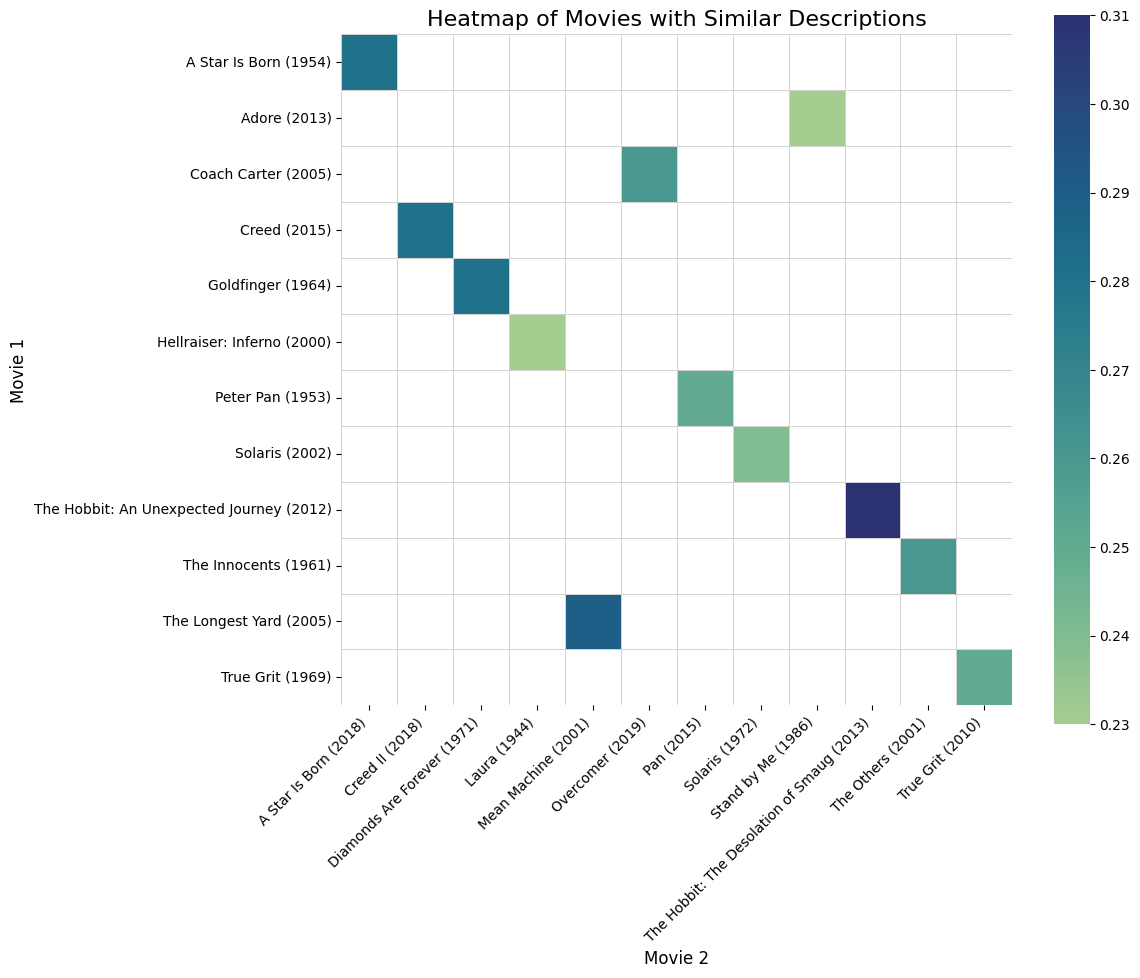

In [ ]:
plot_HeatMap(_similar)